# Library

In [1]:
import os
import random
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#os.environ['TF_DETERMINISTIC_OPS'] = '1'
plt.rcParams["font.family"] = "Malgun Gothic"  

In [2]:
# 시드 고정
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

# Prep

### 긍정 부정 중립

In [3]:
df_fx = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\data\df_investing2.csv")

df_sentiment = pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\crawler\data\naver_finance_news_sentiment_score.csv")

df_fx["date"] = pd.to_datetime(df_fx["date"]).dt.date
df_sentiment["date"] = pd.to_datetime(df_sentiment["date"]).dt.date

# 병합 
df= pd.merge(df_fx, df_sentiment[["date", "sentiment score"]], on="date", how="left")

In [4]:
# 결측치 0으로 채움
df["sentiment score"] = df["sentiment score"].fillna(0)

In [5]:
# scaler 객체 생성
scaler = StandardScaler()

# 'Z-score 정규화 
df['sentiment score'] = scaler.fit_transform(df[['sentiment score']])

### 댓글

In [6]:
df_comment =  pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\crawler\data\investing_comment_sentiment_score.csv")

In [7]:
df_comment['date'] = pd.to_datetime(df_comment['date'], format="%Y-%m-%d", errors="coerce")
#df_binary["date"] = pd.to_datetime(df_binary["date"]).dt.date

In [8]:
df_fx["date"] = pd.to_datetime(df_fx["date"])

In [9]:
df2= pd.merge(df_fx, df_comment[["date", "score", "total_comments"]], on="date", how="left") #, "total_comments"

In [10]:
df2["score"] = df2["score"].fillna(0) #어차피 결측치 없음

In [11]:
scaler = StandardScaler()
df2['score'] = scaler.fit_transform(df2[['score']])

### score 0.95 >

In [12]:
# 0.9 이상 댓글

In [13]:
df_filterd =  pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\crawler\data\investing_comment_sentiment_score.csv")

In [14]:
df_filterd["date"] = pd.to_datetime(df_filterd["date"]).dt.date

In [15]:
df_fx["date"] = pd.to_datetime(df_fx["date"]).dt.date

In [16]:
df3= pd.merge(df_fx, df_filterd[["date", "score", "total_comments"]], on="date", how="left")

In [17]:
df3["score"] = df3["score"].fillna(0)

In [18]:
scaler = StandardScaler()
df3['score'] = scaler.fit_transform(df3[['score']])

In [19]:
# 긍정 부정

In [20]:
#df_filterd2 =  pd.read_csv(r"C:\Users\james\J_Data_Lab\Project-FXCast\crawler\data\naver_finance_news_binary_sentiment_score_filtered.csv")

In [21]:
#df_filterd2["date"] = pd.to_datetime(df_filterd2["date"]).dt.date
#df_fx["date"] = pd.to_datetime(df_fx["date"]).dt.date

In [35]:
df["date"] = pd.to_datetime(df["date"]).dt.date
df_filterd["date"] = pd.to_datetime(df_filterd["date"]).dt.date

In [36]:
df4= pd.merge(df, df_filterd[["date", "score", "total_comments"]], on="date", how="left")

In [37]:
df4["score"] = df4["score"].fillna(0)

In [38]:
scaler = StandardScaler()
df4['score'] = scaler.fit_transform(df4[['score']])

In [39]:
df4

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score,score,total_comments
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,6.445500e+08,70.99,2605.39,42573.73,...,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-1.283978,-1.469888,202
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,8.141300e+08,70.08,2620.00,42992.21,...,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-1.283978,-1.286430,830
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,8.292900e+08,69.53,2634.43,43325.80,...,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-1.283978,0.123131,586
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,6.451000e+08,69.92,2613.20,43297.03,...,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,-0.843971,-0.724579,375
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,6.577100e+08,69.34,2612.93,42906.95,...,1274.2903,4183.5354,3.00,4.645161,1.9,119.52,12368.0,0.036043,-0.356580,252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,2020-01-08,1162.25,1168.30,2151.31,913830000.0,640.94,1.380000e+09,59.97,1555.81,28745.09,...,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,-1.283978,0.640708,41
1182,2020-01-07,1167.30,1167.54,2175.54,568240000.0,663.44,9.703100e+08,64.92,1573.99,28583.68,...,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,1.356063,1.966647,11
1183,2020-01-06,1166.94,1165.89,2155.07,592670000.0,655.31,8.842800e+08,62.99,1565.96,28703.38,...,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,-1.283978,1.216066,13
1184,2020-01-03,1164.95,1157.95,2176.46,631560000.0,669.93,9.038600e+08,63.10,1551.65,28634.88,...,944.3064,2935.6403,1.25,1.750000,1.2,101.02,185.0,-1.283978,-1.889909,30


In [41]:
def eda_basic_info(df, df_name="DataFrame"):
    print(f"\n===== {df_name} =====")
    print("Head (5 rows):")
    display(df.head())
    
    print("\nInfo:")
    print(df.info())
    
    print("\nDescribe (numeric):")
    display(df.describe())
    
    print("\nNull counts:")
    print(df.isnull().sum())
    
    print("="*40)

In [26]:
eda_basic_info(df, "df")


===== df =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-0.843971
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.036043



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1186 non-null   object 
 1   USD_KRW 종가       1186 non-null   float64
 2   USD_KRW 시가       1186 non-null   float64
 3   KOSPI 종가         1186 non-null   float64
 4   KOSPI 거래량        1186 non-null   float64
 5   KOSDAQ 종가        1186 non-null   float64
 6   KOSDAQ 거래량       1186 non-null   float64
 7   WTI Price        1186 non-null   float64
 8   XAU Price        1186 non-null   float64
 9   DJI 종가           1186 non-null   float64
 10  DJI 거래량          1186 non-null   float64
 11  SP500 종가         1186 non-null   float64
 12  M1               1186 non-null   float64
 13  M2               1186 non-null   float64
 14  한국 정책금리          1186 non-null   float64
 15  미국 정책금리          1186 non-null   float64
 16  CPI              1186 non-null   float64
 17  PPI    

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1.186000e+03
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,1.347994e-17
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,1.000422e+00
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,-1.283978e+00
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,-1.283978e+00
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,3.604271e-02
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,1.356063e+00
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,1.356063e+00



Null counts:
date               0
USD_KRW 종가         0
USD_KRW 시가         0
KOSPI 종가           0
KOSPI 거래량          0
KOSDAQ 종가          0
KOSDAQ 거래량         0
WTI Price          0
XAU Price          0
DJI 종가             0
DJI 거래량            0
SP500 종가           0
M1                 0
M2                 0
한국 정책금리            0
미국 정책금리            0
CPI                0
PPI                0
경상수지               0
sentiment score    0
dtype: int64


In [14]:
eda_basic_info(df2, "df2")


===== df2 =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,score,total_comments
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,...,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.188119,202
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,...,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.212048,830
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,...,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.395904,586
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,...,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.285333,375
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,...,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.333333,252



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1186 non-null   datetime64[ns]
 1   USD_KRW 종가      1186 non-null   float64       
 2   USD_KRW 시가      1186 non-null   float64       
 3   KOSPI 종가        1186 non-null   float64       
 4   KOSPI 거래량       1186 non-null   float64       
 5   KOSDAQ 종가       1186 non-null   float64       
 6   KOSDAQ 거래량      1186 non-null   float64       
 7   WTI Price       1186 non-null   float64       
 8   XAU Price       1186 non-null   float64       
 9   DJI 종가          1186 non-null   float64       
 10  DJI 거래량         1186 non-null   float64       
 11  SP500 종가        1186 non-null   float64       
 12  M1              1186 non-null   float64       
 13  M2              1186 non-null   float64       
 14  한국 정책금리         1186 non-null   float64       
 1

,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,score,total_comments
count,1186,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,...,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1186.000000,1186.000000
mean,2022-06-25 11:34:30.151770624,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,...,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,0.379844,208.709949
min,2020-01-02 00:00:00,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,...,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,-0.250000,4.000000
25%,2021-03-29 06:00:00,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,...,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,0.305501,75.000000
50%,2022-06-25 12:00:00,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,...,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,0.375956,150.000000
75%,2023-09-18 18:00:00,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,...,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,0.451808,267.750000
max,2024-12-30 00:00:00,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,...,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,1.000000,1451.000000
std,NaN,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,...,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,0.130490,199.323599



Null counts:
date              0
USD_KRW 종가        0
USD_KRW 시가        0
KOSPI 종가          0
KOSPI 거래량         0
KOSDAQ 종가         0
KOSDAQ 거래량        0
WTI Price         0
XAU Price         0
DJI 종가            0
DJI 거래량           0
SP500 종가          0
M1                0
M2                0
한국 정책금리           0
미국 정책금리           0
CPI               0
PPI               0
경상수지              0
score             0
total_comments    0
dtype: int64


In [18]:
eda_basic_info(df3, "df3")


===== df3 =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,score
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.188119
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.212048
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.395904
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.285333
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.333333



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1186 non-null   object 
 1   USD_KRW 종가  1186 non-null   float64
 2   USD_KRW 시가  1186 non-null   float64
 3   KOSPI 종가    1186 non-null   float64
 4   KOSPI 거래량   1186 non-null   float64
 5   KOSDAQ 종가   1186 non-null   float64
 6   KOSDAQ 거래량  1186 non-null   float64
 7   WTI Price   1186 non-null   float64
 8   XAU Price   1186 non-null   float64
 9   DJI 종가      1186 non-null   float64
 10  DJI 거래량     1186 non-null   float64
 11  SP500 종가    1186 non-null   float64
 12  M1          1186 non-null   float64
 13  M2          1186 non-null   float64
 14  한국 정책금리     1186 non-null   float64
 15  미국 정책금리     1186 non-null   float64
 16  CPI         1186 non-null   float64
 17  PPI         1186 non-null   float64
 18  경상수지        1186 non-null   float64
 19  score       1186 non

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,score
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1186.000000
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,0.379844
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,0.130490
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,-0.250000
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,0.305501
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,0.375956
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,0.451808
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,1.000000



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
M1            0
M2            0
한국 정책금리       0
미국 정책금리       0
CPI           0
PPI           0
경상수지          0
score         0
dtype: int64


In [42]:
eda_basic_info(df4, "df4")


===== df4 =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,...,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score,score,total_comments
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,...,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978,-1.469888,202
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,...,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978,-1.286430,830
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,...,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-1.283978,0.123131,586
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,...,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,-0.843971,-0.724579,375
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,...,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0,0.036043,-0.356580,252



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             1186 non-null   object 
 1   USD_KRW 종가       1186 non-null   float64
 2   USD_KRW 시가       1186 non-null   float64
 3   KOSPI 종가         1186 non-null   float64
 4   KOSPI 거래량        1186 non-null   float64
 5   KOSDAQ 종가        1186 non-null   float64
 6   KOSDAQ 거래량       1186 non-null   float64
 7   WTI Price        1186 non-null   float64
 8   XAU Price        1186 non-null   float64
 9   DJI 종가           1186 non-null   float64
 10  DJI 거래량          1186 non-null   float64
 11  SP500 종가         1186 non-null   float64
 12  M1               1186 non-null   float64
 13  M2               1186 non-null   float64
 14  한국 정책금리          1186 non-null   float64
 15  미국 정책금리          1186 non-null   float64
 16  CPI              1186 non-null   float64
 17  PPI    

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,...,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지,sentiment score,score,total_comments
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,...,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000,1.186000e+03,1.186000e+03,1186.000000
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,...,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894,1.347994e-17,4.792868e-17,208.709949
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,...,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435,1.000422e+00,1.000422e+00,199.323599
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,...,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000,-1.283978e+00,-4.828791e+00,4.000000
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,...,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000,-1.283978e+00,-5.699590e-01,75.000000
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,...,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000,3.604271e-02,-2.980503e-02,150.000000
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,...,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000,1.356063e+00,5.517253e-01,267.750000
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,...,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000,1.356063e+00,4.754519e+00,1451.000000



Null counts:
date               0
USD_KRW 종가         0
USD_KRW 시가         0
KOSPI 종가           0
KOSPI 거래량          0
KOSDAQ 종가          0
KOSDAQ 거래량         0
WTI Price          0
XAU Price          0
DJI 종가             0
DJI 거래량            0
SP500 종가           0
M1                 0
M2                 0
한국 정책금리            0
미국 정책금리            0
CPI                0
PPI                0
경상수지               0
sentiment score    0
score              0
total_comments     0
dtype: int64


In [28]:
eda_basic_info(df_fx, "df_fx")


===== df_fx =====
Head (5 rows):


,date,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지
0,2024-12-30,1469.25,1471.10,2399.49,303960000.0,678.19,644550000.0,70.99,2605.39,42573.73,383300000.0,5906.94,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
1,2024-12-27,1472.50,1468.40,2404.77,311290000.0,665.97,814130000.0,70.08,2620.00,42992.21,376960000.0,5970.84,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
2,2024-12-26,1467.08,1457.21,2429.67,322800000.0,675.64,829290000.0,69.53,2634.43,43325.80,270360000.0,6037.59,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
3,2024-12-24,1458.93,1453.28,2440.52,386780000.0,680.11,645100000.0,69.92,2613.20,43297.03,230410000.0,6040.04,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0
4,2024-12-23,1451.28,1446.05,2442.01,428170000.0,679.24,657710000.0,69.34,2612.93,42906.95,449400000.0,5974.07,1274.2903,4183.5354,3.0,4.645161,1.9,119.52,12368.0



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1186 non-null   object 
 1   USD_KRW 종가  1186 non-null   float64
 2   USD_KRW 시가  1186 non-null   float64
 3   KOSPI 종가    1186 non-null   float64
 4   KOSPI 거래량   1186 non-null   float64
 5   KOSDAQ 종가   1186 non-null   float64
 6   KOSDAQ 거래량  1186 non-null   float64
 7   WTI Price   1186 non-null   float64
 8   XAU Price   1186 non-null   float64
 9   DJI 종가      1186 non-null   float64
 10  DJI 거래량     1186 non-null   float64
 11  SP500 종가    1186 non-null   float64
 12  M1          1186 non-null   float64
 13  M2          1186 non-null   float64
 14  한국 정책금리     1186 non-null   float64
 15  미국 정책금리     1186 non-null   float64
 16  CPI         1186 non-null   float64
 17  PPI         1186 non-null   float64
 18  경상수지        1186 non-null   float64
dtypes: float64(18), obje

,USD_KRW 종가,USD_KRW 시가,KOSPI 종가,KOSPI 거래량,KOSDAQ 종가,KOSDAQ 거래량,WTI Price,XAU Price,DJI 종가,DJI 거래량,SP500 종가,M1,M2,한국 정책금리,미국 정책금리,CPI,PPI,경상수지
count,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1.186000e+03,1186.000000,1186.000000,1186.000000,1186.000000,1186.00000,1186.000000,1186.000000,1186.000000
mean,1256.282968,1256.633221,2596.073440,7.131867e+08,841.160118,1.306049e+09,69.533440,1937.514081,33603.138786,3.687432e+08,4250.179671,1219.394587,3616.388458,2.037789,2.60763,2.811298,111.501433,5333.790894
std,93.743223,93.787299,339.282251,3.554851e+08,114.428855,5.210409e+08,23.291945,263.590609,4657.788950,1.128756e+08,764.021938,103.680673,347.336672,1.303587,2.31595,1.658261,7.401748,4255.906435
min,1083.530000,1083.870000,1457.640000,8.245100e+05,428.350000,6.196200e+08,7.790000,1471.000000,18591.930000,1.170400e+08,2237.400000,944.306400,2935.640300,0.500000,0.25000,-0.200000,98.930000,-4205.000000
25%,1181.822500,1182.460000,2399.310000,4.629025e+08,762.185000,9.524700e+08,62.090000,1778.307500,31022.087500,3.016050e+08,3810.150000,1184.088000,3309.121000,0.548387,0.25000,1.425000,103.890000,1862.000000
50%,1265.610000,1266.325000,2568.480000,6.137650e+08,847.505000,1.170000e+09,73.735000,1870.390000,33913.620000,3.433250e+08,4200.010000,1221.110000,3718.332800,1.750000,1.75000,2.700000,116.270000,6365.000000
75%,1333.020000,1333.395000,2758.637500,8.662025e+08,919.412500,1.500000e+09,82.030000,1985.455000,35627.822500,4.021650e+08,4591.015000,1287.187300,3843.786700,3.500000,5.25000,3.800000,117.500000,7438.000000
max,1472.500000,1471.100000,3305.210000,3.460000e+09,1060.000000,5.070000e+09,126.470000,2786.190000,45014.040000,1.220000e+09,6090.270000,1371.920900,4183.535400,3.500000,5.50000,6.300000,119.560000,13096.000000



Null counts:
date          0
USD_KRW 종가    0
USD_KRW 시가    0
KOSPI 종가      0
KOSPI 거래량     0
KOSDAQ 종가     0
KOSDAQ 거래량    0
WTI Price     0
XAU Price     0
DJI 종가        0
DJI 거래량       0
SP500 종가      0
M1            0
M2            0
한국 정책금리       0
미국 정책금리       0
CPI           0
PPI           0
경상수지          0
dtype: int64


# Prep 2(VIF, PCA, NONE)

In [19]:
# VIF
def reduce_vif(df, thresh=10.0):
    variables = df.columns.tolist()
    dropped = True
    while dropped:
        dropped = False
        vif_data = pd.DataFrame()
        vif_data["feature"] = variables
        vif_data["VIF"] = [variance_inflation_factor(df[variables].values, i) for i in range(len(variables))]
        max_vif = vif_data["VIF"].max()
        if max_vif > thresh:
            max_feature = vif_data.sort_values("VIF", ascending=False)["feature"].iloc[0]
            print(f"Dropping {max_feature} with VIF = {max_vif:.2f}")
            variables.remove(max_feature)
            dropped = True
    return df[variables]

In [20]:
# ===== 시퀀스 데이터 생성 함수 =====
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features[i : i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

In [21]:
# 데이터 전처리 - PCA, pca_n_components 몇으로 설정? / VIF, vif_threshold 몇으로 설정? / NONE 버전
def prepare_data(df, method="none", window_size=5, vif_threshold=10, pca_n_components=0.99):
    target_column = 'USD_KRW 종가'
    columns_to_drop = ['date', target_column]
    
    # 독립변수와 종속변수 분리
    features = df.drop(columns=columns_to_drop)
    # 원래 변수 이름 저장 
    feature_names = list(features.columns)
    target = df[target_column].values
    
    # VIF 버전: 다중공선성이 높은 변수 제거 후 변수 이름 업데이트
    if method == "vif":
        features = reduce_vif(features, thresh=vif_threshold)
        feature_names = list(features.columns)
    
    # numpy array로 변환
    features_array = features.values
    
    # 스케일링
    scaler_x = MinMaxScaler()
    scaler_y = MinMaxScaler()
    features_scaled = scaler_x.fit_transform(features_array)
    target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))
    
    # PCA 버전: 차원 축소
    if method == "pca":
        pca = PCA(n_components=pca_n_components)
        features_scaled = pca.fit_transform(features_scaled)
        # print("PCA 적용:")
        # print(f"  원래 변수 개수: {len(feature_names)} -> 주성분 개수: {pca.n_components_}")
        # print("  각 주성분에 대한 변수 기여도 (loadings):")
        # for i, component in enumerate(pca.components_):
        #     loadings = {feature_names[j]: component[j] for j in range(len(feature_names))}
        #     sorted_loadings = sorted(loadings.items(), key=lambda x: abs(x[1]), reverse=True)
        #     print(f"  주성분 {i+1} (설명분산: {pca.explained_variance_ratio_[i]*100:.2f}%):")
        #     for feat, loading in sorted_loadings:
        #         print(f"    {feat}: {loading:.4f}")
    
    X, y = create_sequences(features_scaled, target_scaled, window_size)
    
    # 시간 순서대로 학습/테스트 분할 (80:20)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    return X_train, X_test, y_train, y_test, scaler_y

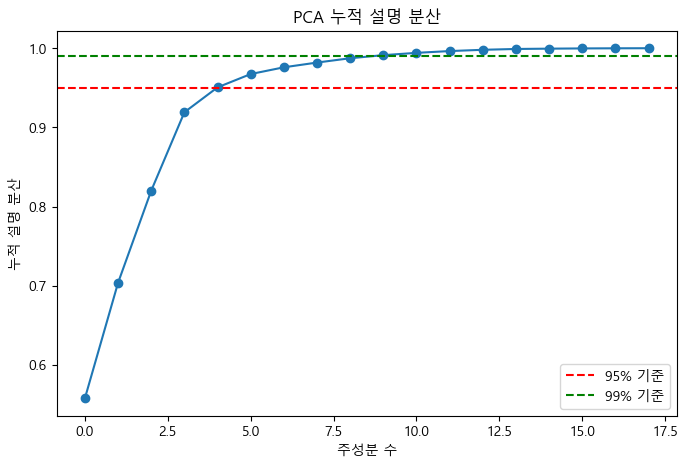

In [22]:
target_column = 'USD_KRW 종가'
columns_to_drop = ['date', target_column]
features = df.drop(columns=columns_to_drop)

# 스케일링
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features.values)

# PCA 수행
pca = PCA().fit(features_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# 누적 설명 분산 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("주성분 수")
plt.ylabel("누적 설명 분산")
plt.axhline(y=0.95, color='r', linestyle='--', label='95% 기준')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% 기준')
plt.title("PCA 누적 설명 분산")
plt.legend()
plt.show()

# 주성분 수 확인
# n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
# print(f"95% 설명 분산을 위해 필요한 주성분 수: {n_components_95}\n")

# # 각 주성분에 대한 변수 기여도 출력
# print("각 주성분의 변수 기여도 (Loadings):")
# for i in range(n_components_95):
    
#     loadings = pd.Series(pca.components_[i], index=features.columns)
#     loadings_sorted = loadings.reindex(loadings.abs().sort_values(ascending=False).index)
#     print(f"\n주성분 {i+1} (설명 분산: {pca.explained_variance_ratio_[i]*100:.2f}%):")
#     print(loadings_sorted)

각 변수의 VIF 값:
                 변수           VIF
11               M2  43563.448379
10               M1  14972.511724
15              PPI  14760.705426
7            DJI 종가   3572.427735
9          SP500 종가   2851.158944
0        USD_KRW 시가   2607.895420
1          KOSPI 종가    997.052432
12          한국 정책금리    896.056697
3         KOSDAQ 종가    624.911027
6         XAU Price    593.330475
13          미국 정책금리    480.689949
5         WTI Price    123.834920
14              CPI     80.927768
4        KOSDAQ 거래량     21.991830
8           DJI 거래량     15.959666
2         KOSPI 거래량     14.628675
16             경상수지      7.450662
17  sentiment score      1.017792


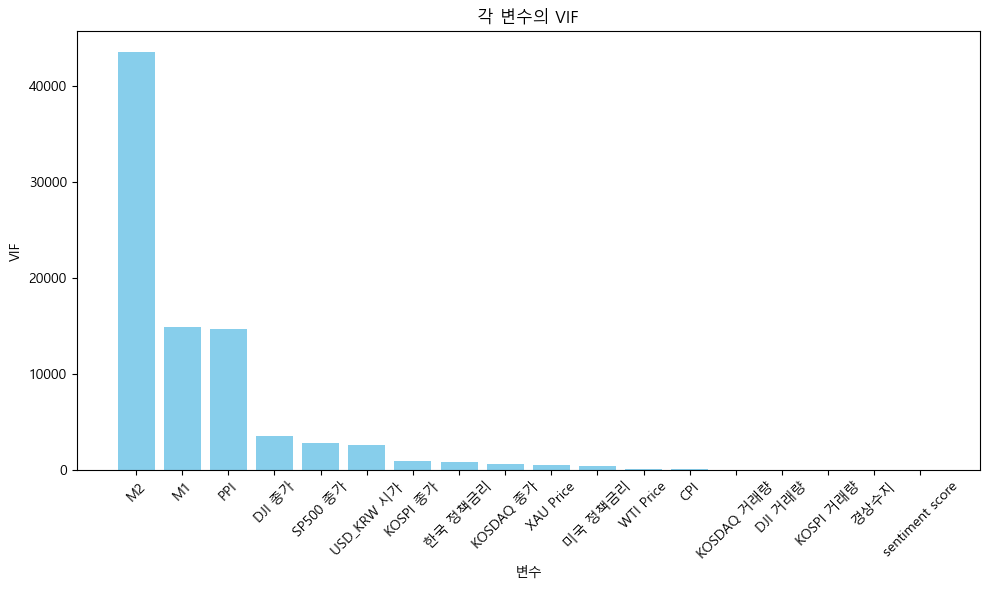

In [23]:
target_column = 'USD_KRW 종가'
columns_to_drop = ['date', target_column]
features = df.drop(columns=columns_to_drop)

# VIF 계산 함수 정의
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["변수"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    return vif_data

# VIF 계산
vif_df = calculate_vif(features)

# 내림차순 정렬
vif_sorted = vif_df.sort_values("VIF", ascending=False)
print("각 변수의 VIF 값:")
print(vif_sorted)

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(vif_sorted["변수"], vif_sorted["VIF"], color='skyblue')
plt.xlabel("변수")
plt.ylabel("VIF")
plt.title("각 변수의 VIF")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Modeling

In [24]:
def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_lstm(input_shape):
    model = Sequential([
        Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        LSTM(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_cnn_gru(input_shape):
    model = Sequential([
        Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        GRU(50, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [25]:
# 모델 학습 및 예측 결과 
def train_models_for_method(df, method="none", window_size=5, epochs=50, batch_size=16):
    # 데이터 전처리
    X_train, X_test, y_train, y_test, scaler_y = prepare_data(df, method=method, window_size=window_size)
    input_shape = (X_train.shape[1], X_train.shape[2])
    y_test_inv = scaler_y.inverse_transform(y_test)
    early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    
    results = {}  # 모델별 평가 지표와 예측값 저장
    # LSTM 모델
    model = build_lstm(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['LSTM'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    # GRU 모델
    model = build_gru(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['GRU'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    # CNN-LSTM 모델
    model = build_cnn_lstm(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['CNN-LSTM'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    # CNN-GRU 모델
    model = build_cnn_gru(input_shape)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])
    pred = scaler_y.inverse_transform(model.predict(X_test))
    mse_val = mean_squared_error(y_test_inv, pred)
    mape_val = mean_absolute_percentage_error(y_test_inv, pred) * 100
    results['CNN-GRU'] = {'metrics': {'mse': mse_val, 'mape': mape_val}, 'predictions': pred}
    
    return results, y_test_inv

In [26]:
# 전체 실험 실행
def run_experiments(df, window_size=5, epochs=50, batch_size=16):
    methods = ['none', 'vif', 'pca']
    final_results = {}  # 각 전처리 방식별 결과 저장
    for method in methods:
        print(f"\n==== Processing method: {method.upper()} ====")
        model_results, y_test_inv = train_models_for_method(df, method=method, window_size=window_size, epochs=epochs, batch_size=batch_size)
        final_results[method] = {'models': model_results, 'y_test_inv': y_test_inv}
    return final_results

In [27]:
# 그래프 출력 
def plot_time_series_predictions(y_test_inv, predictions, method):
    plt.figure(figsize=(12,6))
    plt.plot(y_test_inv, label='Actual')
    for model_name, data in predictions.items():
        plt.plot(data['predictions'], label=model_name)
    plt.title(f'USD_KRW 종가 예측 결과 비교 ({method.upper()} 전처리)')
    plt.xlabel('Time Step')
    plt.ylabel('USD_KRW 종가')
    plt.legend()
    plt.show()

# Result

In [43]:
df['date'] = pd.to_datetime(df['date'])
df2['date'] = pd.to_datetime(df2['date'])
df3['date'] = pd.to_datetime(df3['date'])
df4['date'] = pd.to_datetime(df4['date'])
df_fx['date'] = pd.to_datetime(df_fx['date'])

In [44]:
# 긍정 부정 중립
experiment_results_df1 = run_experiments(df, window_size=5, epochs=50, batch_size=16)
# 긍정 부정
experiment_results_df2 = run_experiments(df2, window_size=5, epochs=50, batch_size=16)
# 감정 분석 x
experiment_results_df3 = run_experiments(df_fx, window_size=5, epochs=50, batch_size=16)

# score 0.90이상 긍정 부정
experiment_results_df4 = run_experiments(df3, window_size=5, epochs=50, batch_size=16)
# 뉴스 + 댓글
experiment_results_df5 = run_experiments(df4, window_size=5, epochs=50, batch_size=16)


==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43563.45
Dropping PPI with VIF = 8287.74
Dropping M1 with VIF = 2995.95
Dropping DJI 종가 with VIF = 2395.89
Dropping KOSPI 종가 with VIF = 708.73
Dropping 한국 정책금리 with VIF = 518.93
Dropping XAU Price with VIF = 389.56
Dropping SP500 종가 with VIF = 130.69
Dropping USD_KRW 시가 with VIF = 97.60
Dropping WTI Price with VIF = 58.55
Dropping KOSDAQ 종가 with VIF = 42.23
Dropping KOSDAQ 거래량 with VIF = 14.70


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43706.90
Dropping PPI with VIF = 8964.73
Dropping M1 with VIF = 3061.43
Dropping DJI 종가 with VIF = 2475.64
Dropping KOSPI 종가 with VIF = 717.44
Dropping 한국 정책금리 with VIF = 522.64
Dropping XAU Price with VIF = 392.82
Dropping SP500 종가 with VIF = 132.42
Dropping USD_KRW 시가 with VIF = 106.49
Dropping WTI Price with VIF = 59.73
Dropping KOSDAQ 종가 with VIF = 43.62
Dropping KOSDAQ 거래량 with VIF = 14.76


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43563.43
Dropping PPI with VIF = 8287.29
Dropping M1 with VIF = 2995.95
Dropping DJI 종가 with VIF = 2395.88
Dropping KOSPI 종가 with VIF = 707.48
Dropping 한국 정책금리 with VIF = 518.85
Dropping XAU Price with VIF = 388.21
Dropping SP500 종가 with VIF = 130.56
Dropping USD_KRW 시가 with VIF = 97.60
Dropping WTI Price with VIF = 58.17
Dropping KOSDAQ 종가 with VIF = 42.20
Dropping KOSDAQ 거래량 with VIF = 14.68


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43706.90
Dropping PPI with VIF = 8964.73
Dropping M1 with VIF = 3061.43
Dropping DJI 종가 with VIF = 2475.64
Dropping KOSPI 종가 with VIF = 717.44
Dropping 한국 정책금리 with VIF = 522.64
Dropping XAU Price with VIF = 392.82
Dropping SP500 종가 with VIF = 132.42
Dropping USD_KRW 시가 with VIF = 106.49
Dropping WTI Price with VIF = 59.73
Dropping KOSDAQ 종가 with VIF = 43.62
Dropping KOSDAQ 거래량 with VIF = 14.76


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

==== Processing method: NONE ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: VIF ====
Dropping M2 with VIF = 43707.47
Dropping PPI with VIF = 8968.80
Dropping M1 with VIF = 3061.56
Dropping DJI 종가 with VIF = 2475.69
Dropping KOSPI 종가 with VIF = 718.83
Dropping 한국 정책금리 with VIF = 522.77
Dropping XAU Price with VIF = 393.95
Dropping SP500 종가 with VIF = 132.54
Dropping USD_KRW 시가 with VIF = 106.53
Dropping WTI Price with VIF = 60.14
Dropping KOSDAQ 종가 with VIF = 43.66
Dropping KOSDAQ 거래량 with VIF = 14.77


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

==== Processing method: PCA ====


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


C:\Users\james\anaconda3\envs\my_new_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [45]:
print("===== 모델 평가 결과 비교 =====")
rows = []
for dataset_name, experiment_results in zip(['df1', 'df2','df_fx','df3','df4'], 
                                            [experiment_results_df1, experiment_results_df2, experiment_results_df3,
                                             experiment_results_df4, experiment_results_df5]):
    for method, result in experiment_results.items():
        for model_name, model_data in result['models'].items():
            mse_val = model_data['metrics']['mse']
            mape_val = model_data['metrics']['mape']
            rows.append({
                '데이터셋': dataset_name,
                '방식': method,
                '모델명': model_name,
                'MSE': mse_val,
                'MAPE (%)': mape_val
            })

results_compare_df = pd.DataFrame(rows)
results_compare_df

===== 모델 평가 결과 비교 =====


,데이터셋,방식,모델명,MSE,MAPE (%)
0,df1,none,LSTM,187.616787,0.986985
1,df1,none,GRU,75.485860,0.621036
2,df1,none,CNN-LSTM,1140.891126,2.440679
3,df1,none,CNN-GRU,592.198401,1.736310
4,df1,vif,LSTM,6534.455795,5.805890
5,df1,vif,GRU,5183.473070,5.091632
6,df1,vif,CNN-LSTM,7183.151417,5.983209
7,df1,vif,CNN-GRU,7414.208316,6.080440
8,df1,pca,LSTM,214.824359,1.020074
9,df1,pca,GRU,483.153779,1.585260


In [ ]:
# 댓글 감정 + 갯수
데이터셋	방식	모델명	MSE	MAPE (%)
0	df1	none	LSTM	293.905031	1.203631
1	df1	none	GRU	392.567275	1.397443
2	df1	none	CNN-LSTM	1010.979977	2.283962
3	df1	none	CNN-GRU	1172.298806	2.453696
4	df1	vif	LSTM	5927.840862	5.538848
5	df1	vif	GRU	5040.625718	5.013822
6	df1	vif	CNN-LSTM	6831.169728	5.836172
7	df1	vif	CNN-GRU	8116.352459	6.402337
8	df1	pca	LSTM	941.015700	2.228808
9	df1	pca	GRU	295.035435	1.214328
10	df1	pca	CNN-LSTM	458.444769	1.419046
11	df1	pca	CNN-GRU	881.260956	2.224403
12	df2	none	LSTM	876.926797	2.192978
13	df2	none	GRU	237.674693	1.120974
14	df2	none	CNN-LSTM	528.933985	1.671238
15	df2	none	CNN-GRU	381.913453	1.413210
16	df2	vif	LSTM	5983.386420	5.402992
17	df2	vif	GRU	5718.270525	5.153253
18	df2	vif	CNN-LSTM	6493.594188	5.645184
19	df2	vif	CNN-GRU	6772.971676	5.826537
20	df2	pca	LSTM	154.507184	0.840034
21	df2	pca	GRU	133.690630	0.788750
22	df2	pca	CNN-LSTM	377.308325	1.256342
23	df2	pca	CNN-GRU	1364.298153	2.763543
24	df_fx	none	LSTM	254.342816	1.165113
25	df_fx	none	GRU	99.235592	0.645972
26	df_fx	none	CNN-LSTM	719.624579	1.925850
27	df_fx	none	CNN-GRU	1455.805342	2.789212
28	df_fx	vif	LSTM	5441.124470	5.317605
29	df_fx	vif	GRU	6099.774729	5.669989
30	df_fx	vif	CNN-LSTM	7682.739860	6.190135
31	df_fx	vif	CNN-GRU	6796.969453	5.851600
32	df_fx	pca	LSTM	1232.047003	2.720122
33	df_fx	pca	GRU	501.707065	1.663516
34	df_fx	pca	CNN-LSTM	755.104138	1.985759
35	df_fx	pca	CNN-GRU	1351.707695	2.799833

# 오로지 댓글 감정
	데이터셋	방식	모델명	MSE	MAPE (%)
0	df1	none	LSTM	293.905031	1.203631
1	df1	none	GRU	392.567275	1.397443
2	df1	none	CNN-LSTM	1010.979977	2.283962
3	df1	none	CNN-GRU	1172.298806	2.453696
4	df1	vif	LSTM	5927.840862	5.538848
5	df1	vif	GRU	5040.625718	5.013822
6	df1	vif	CNN-LSTM	6831.169728	5.836172
7	df1	vif	CNN-GRU	8116.352459	6.402337
8	df1	pca	LSTM	941.015700	2.228808
9	df1	pca	GRU	295.035435	1.214328
10	df1	pca	CNN-LSTM	458.444769	1.419046
11	df1	pca	CNN-GRU	881.260956	2.224403
12	df2	none	LSTM	912.926901	2.239659
13	df2	none	GRU	165.389888	0.920419
14	df2	none	CNN-LSTM	518.139277	1.599303
15	df2	none	CNN-GRU	1740.703133	3.018956
16	df2	vif	LSTM	5622.891422	5.303153
17	df2	vif	GRU	7105.134818	6.054340
18	df2	vif	CNN-LSTM	7096.794201	5.835129
19	df2	vif	CNN-GRU	7930.252967	6.255042
20	df2	pca	LSTM	202.464013	0.978946
21	df2	pca	GRU	126.560564	0.751984
22	df2	pca	CNN-LSTM	1014.029968	2.373415
23	df2	pca	CNN-GRU	1848.983586	3.298362
24	df_fx	none	LSTM	254.342816	1.165113
25	df_fx	none	GRU	99.235592	0.645972
26	df_fx	none	CNN-LSTM	719.624579	1.925850
27	df_fx	none	CNN-GRU	1455.805342	2.789212
28	df_fx	vif	LSTM	5441.124470	5.317605
29	df_fx	vif	GRU	6099.774729	5.669989
30	df_fx	vif	CNN-LSTM	7682.739860	6.190135
31	df_fx	vif	CNN-GRU	6796.969453	5.851600
32	df_fx	pca	LSTM	1232.047003	2.720122
33	df_fx	pca	GRU	501.707065	1.663516
34	df_fx	pca	CNN-LSTM	755.104138	1.985759
35	df_fx	pca	CNN-GRU	1351.707695	2.799833

# 0.9 이상 댓글 감정
	데이터셋	방식	모델명	MSE	MAPE (%)
0	df1	none	LSTM	293.905031	1.203631
1	df1	none	GRU	392.567275	1.397443
2	df1	none	CNN-LSTM	1010.979977	2.283962
3	df1	none	CNN-GRU	1172.298806	2.453696
4	df1	vif	LSTM	5927.840862	5.538848
5	df1	vif	GRU	5040.625718	5.013822
6	df1	vif	CNN-LSTM	6831.169728	5.836172
7	df1	vif	CNN-GRU	8116.352459	6.402337
8	df1	pca	LSTM	941.015700	2.228808
9	df1	pca	GRU	295.035435	1.214328
10	df1	pca	CNN-LSTM	458.444769	1.419046
11	df1	pca	CNN-GRU	881.260956	2.224403
12	df2	none	LSTM	912.926901	2.239659
13	df2	none	GRU	165.389888	0.920419
14	df2	none	CNN-LSTM	518.139277	1.599303
15	df2	none	CNN-GRU	1740.703133	3.018956
16	df2	vif	LSTM	5622.891422	5.303153
17	df2	vif	GRU	7105.134818	6.054340
18	df2	vif	CNN-LSTM	7096.794201	5.835129
19	df2	vif	CNN-GRU	7930.252967	6.255042
20	df2	pca	LSTM	202.464013	0.978946
21	df2	pca	GRU	126.560564	0.751984
22	df2	pca	CNN-LSTM	1014.029968	2.373415
23	df2	pca	CNN-GRU	1848.983586	3.298362
24	df_fx	none	LSTM	254.342816	1.165113
25	df_fx	none	GRU	99.235592	0.645972
26	df_fx	none	CNN-LSTM	719.624579	1.925850
27	df_fx	none	CNN-GRU	1455.805342	2.789212
28	df_fx	vif	LSTM	5441.124470	5.317605
29	df_fx	vif	GRU	6099.774729	5.669989
30	df_fx	vif	CNN-LSTM	7682.739860	6.190135
31	df_fx	vif	CNN-GRU	6796.969453	5.851600
32	df_fx	pca	LSTM	1232.047003	2.720122
33	df_fx	pca	GRU	501.707065	1.663516
34	df_fx	pca	CNN-LSTM	755.104138	1.985759
35	df_fx	pca	CNN-GRU	1351.707695	2.799833
36	df3	none	LSTM	174.086798	0.944476
37	df3	none	GRU	99.222206	0.651782
38	df3	none	CNN-LSTM	1332.760843	2.724341
39	df3	none	CNN-GRU	789.796601	2.015568
40	df3	vif	LSTM	5754.255379	5.414687
41	df3	vif	GRU	4851.214740	4.921270
42	df3	vif	CNN-LSTM	7384.417443	5.968883
43	df3	vif	CNN-GRU	7567.648289	6.099247
44	df3	pca	LSTM	737.081850	1.956280
45	df3	pca	GRU	129.507006	0.740476
46	df3	pca	CNN-LSTM	521.064068	1.591717
47	df3	pca	CNN-GRU	2280.968928	3.671600

#  0.9 이상 댓글 감정 + 갯수
데이터셋	방식	모델명	MSE	MAPE (%)
0	df1	none	LSTM	293.905031	1.203631
1	df1	none	GRU	392.567275	1.397443
2	df1	none	CNN-LSTM	1010.979977	2.283962
3	df1	none	CNN-GRU	1172.298806	2.453696
4	df1	vif	LSTM	5927.840862	5.538848
5	df1	vif	GRU	5040.625718	5.013822
6	df1	vif	CNN-LSTM	6831.169728	5.836172
7	df1	vif	CNN-GRU	8116.352459	6.402337
8	df1	pca	LSTM	941.015700	2.228808
9	df1	pca	GRU	295.035435	1.214328
10	df1	pca	CNN-LSTM	458.444769	1.419046
11	df1	pca	CNN-GRU	881.260956	2.224403
12	df2	none	LSTM	876.926797	2.192978
13	df2	none	GRU	237.674693	1.120974
14	df2	none	CNN-LSTM	528.933985	1.671238
15	df2	none	CNN-GRU	381.913453	1.413210
16	df2	vif	LSTM	5983.386420	5.402992
17	df2	vif	GRU	5718.270525	5.153253
18	df2	vif	CNN-LSTM	6493.594188	5.645184
19	df2	vif	CNN-GRU	6772.971676	5.826537
20	df2	pca	LSTM	154.507184	0.840034
21	df2	pca	GRU	133.690630	0.788750
22	df2	pca	CNN-LSTM	377.308325	1.256342
23	df2	pca	CNN-GRU	1364.298153	2.763543
24	df_fx	none	LSTM	254.342816	1.165113
25	df_fx	none	GRU	99.235592	0.645972
26	df_fx	none	CNN-LSTM	719.624579	1.925850
27	df_fx	none	CNN-GRU	1455.805342	2.789212
28	df_fx	vif	LSTM	5441.124470	5.317605
29	df_fx	vif	GRU	6099.774729	5.669989
30	df_fx	vif	CNN-LSTM	7682.739860	6.190135
31	df_fx	vif	CNN-GRU	6796.969453	5.851600
32	df_fx	pca	LSTM	1232.047003	2.720122
33	df_fx	pca	GRU	501.707065	1.663516
34	df_fx	pca	CNN-LSTM	755.104138	1.985759
35	df_fx	pca	CNN-GRU	1351.707695	2.799833
36	df3	none	LSTM	235.110506	1.100124
37	df3	none	GRU	102.392622	0.670695
38	df3	none	CNN-LSTM	1330.480108	2.678723
39	df3	none	CNN-GRU	515.819702	1.611752
40	df3	vif	LSTM	5229.419583	4.929682
41	df3	vif	GRU	4372.852824	4.500696
42	df3	vif	CNN-LSTM	7116.380990	5.797108
43	df3	vif	CNN-GRU	6958.718884	5.782755
44	df3	pca	LSTM	736.695124	2.010416
45	df3	pca	GRU	73.155971	0.587159
46	df3	pca	CNN-LSTM	623.357692	1.763679
47	df3	pca	CNN-GRU	530.534019	1.625075

# 뉴스 + 댓글
데이터셋	방식	모델명	MSE	MAPE (%)
0	df1	none	LSTM	187.616787	0.986985
1	df1	none	GRU	75.485860	0.621036
2	df1	none	CNN-LSTM	1140.891126	2.440679
3	df1	none	CNN-GRU	592.198401	1.736310
4	df1	vif	LSTM	6534.455795	5.805890
5	df1	vif	GRU	5183.473070	5.091632
6	df1	vif	CNN-LSTM	7183.151417	5.983209
7	df1	vif	CNN-GRU	7414.208316	6.080440
8	df1	pca	LSTM	214.824359	1.020074
9	df1	pca	GRU	483.153779	1.585260
10	df1	pca	CNN-LSTM	608.318301	1.731220
11	df1	pca	CNN-GRU	792.457407	2.109227
12	df2	none	LSTM	188.372277	0.965038
13	df2	none	GRU	104.685467	0.729393
14	df2	none	CNN-LSTM	734.503910	1.962331
15	df2	none	CNN-GRU	419.708041	1.454993
16	df2	vif	LSTM	4637.506402	4.585090
17	df2	vif	GRU	5870.305446	5.277249
18	df2	vif	CNN-LSTM	6191.259391	5.464204
19	df2	vif	CNN-GRU	5790.174335	5.413754
20	df2	pca	LSTM	267.002220	1.150504
21	df2	pca	GRU	200.514655	0.977113
22	df2	pca	CNN-LSTM	735.940069	2.001173
23	df2	pca	CNN-GRU	798.895979	2.110328
24	df_fx	none	LSTM	337.977775	1.336228
25	df_fx	none	GRU	241.653468	0.932916
26	df_fx	none	CNN-LSTM	1277.661757	2.551547
27	df_fx	none	CNN-GRU	748.466748	1.945643
28	df_fx	vif	LSTM	5708.599513	5.430273
29	df_fx	vif	GRU	5869.193956	5.527179
30	df_fx	vif	CNN-LSTM	6842.697473	5.860352
31	df_fx	vif	CNN-GRU	5890.947926	5.344435
32	df_fx	pca	LSTM	649.468447	1.866716
33	df_fx	pca	GRU	148.137503	0.765593
34	df_fx	pca	CNN-LSTM	687.249601	1.918802
35	df_fx	pca	CNN-GRU	1969.352258	3.409750
36	df3	none	LSTM	134.344229	0.771774
37	df3	none	GRU	76.627137	0.550816
38	df3	none	CNN-LSTM	942.413670	2.220994
39	df3	none	CNN-GRU	432.448513	1.465492
40	df3	vif	LSTM	6113.720712	5.585752
41	df3	vif	GRU	5591.458808	5.306266
42	df3	vif	CNN-LSTM	6387.358248	5.578084
43	df3	vif	CNN-GRU	6287.660098	5.543946
44	df3	pca	LSTM	116.068772	0.746614
45	df3	pca	GRU	80.361607	0.620888
46	df3	pca	CNN-LSTM	1770.248218	3.142133
47	df3	pca	CNN-GRU	813.078345	2.035287
48	df4	none	LSTM	525.123806	1.587248
49	df4	none	GRU	105.079047	0.733743
50	df4	none	CNN-LSTM	1140.316309	2.503327
51	df4	none	CNN-GRU	903.903349	2.167604
52	df4	vif	LSTM	4784.829946	4.606664
53	df4	vif	GRU	5138.879040	4.819833
54	df4	vif	CNN-LSTM	7341.425691	6.046614
55	df4	vif	CNN-GRU	7302.317851	5.920368
56	df4	pca	LSTM	1539.251632	2.937067
57	df4	pca	GRU	117.900228	0.699856
58	df4	pca	CNN-LSTM	732.853035	1.964219
59	df4	pca	CNN-GRU	2020.184559	3.495409

In [ ]:
# 댓글 감정 + 갯수
12	df2	none	LSTM	876.926797	2.192978
13	df2	none	GRU	237.674693	1.120974
14	df2	none	CNN-LSTM	528.933985	1.671238
15	df2	none	CNN-GRU	381.913453	1.413210
16	df2	vif	LSTM	5983.386420	5.402992
17	df2	vif	GRU	5718.270525	5.153253
18	df2	vif	CNN-LSTM	6493.594188	5.645184
19	df2	vif	CNN-GRU	6772.971676	5.826537
20	df2	pca	LSTM	154.507184	0.840034
21	df2	pca	GRU	133.690630	0.788750
22	df2	pca	CNN-LSTM	377.308325	1.256342
23	df2	pca	CNN-GRU	1364.298153	2.763543

In [ ]:
# 오로지 댓글 감정
12	df2	none	LSTM	912.926901	2.239659
13	df2	none	GRU	165.389888	0.920419
14	df2	none	CNN-LSTM	518.139277	1.599303
15	df2	none	CNN-GRU	1740.703133	3.018956
16	df2	vif	LSTM	5622.891422	5.303153
17	df2	vif	GRU	7105.134818	6.054340
18	df2	vif	CNN-LSTM	7096.794201	5.835129
19	df2	vif	CNN-GRU	7930.252967	6.255042
20	df2	pca	LSTM	202.464013	0.978946
21	df2	pca	GRU	126.560564	0.751984
22	df2	pca	CNN-LSTM	1014.029968	2.373415
23	df2	pca	CNN-GRU	1848.983586	3.298362

In [ ]:
# 0.9 이상 댓글 감정
36	df3	none	LSTM	174.086798	0.944476
37	df3	none	GRU	99.222206	0.651782
38	df3	none	CNN-LSTM	1332.760843	2.724341
39	df3	none	CNN-GRU	789.796601	2.015568
40	df3	vif	LSTM	5754.255379	5.414687
41	df3	vif	GRU	4851.214740	4.921270
42	df3	vif	CNN-LSTM	7384.417443	5.968883
43	df3	vif	CNN-GRU	7567.648289	6.099247
44	df3	pca	LSTM	737.081850	1.956280
45	df3	pca	GRU	129.507006	0.740476
46	df3	pca	CNN-LSTM	521.064068	1.591717
47	df3	pca	CNN-GRU	2280.968928	3.671600

In [ ]:
# 0.9 이상 댓글 + 갯수
36	df3	none	LSTM	235.110506	1.100124
37	df3	none	GRU	102.392622	0.670695
38	df3	none	CNN-LSTM	1330.480108	2.678723
39	df3	none	CNN-GRU	515.819702	1.611752
40	df3	vif	LSTM	5229.419583	4.929682
41	df3	vif	GRU	4372.852824	4.500696
42	df3	vif	CNN-LSTM	7116.380990	5.797108
43	df3	vif	CNN-GRU	6958.718884	5.782755
44	df3	pca	LSTM	736.695124	2.010416
45	df3	pca	GRU	73.155971	0.587159
46	df3	pca	CNN-LSTM	623.357692	1.763679
47	df3	pca	CNN-GRU	530.534019	1.625075

In [ ]:
# 뉴스 + 0.9이상 댓글 + 갯수
48	df4	none	LSTM	525.123806	1.587248
49	df4	none	GRU	105.079047	0.733743
50	df4	none	CNN-LSTM	1140.316309	2.503327
51	df4	none	CNN-GRU	903.903349	2.167604
52	df4	vif	LSTM	4784.829946	4.606664
53	df4	vif	GRU	5138.879040	4.819833
54	df4	vif	CNN-LSTM	7341.425691	6.046614
55	df4	vif	CNN-GRU	7302.317851	5.920368
56	df4	pca	LSTM	1539.251632	2.937067
57	df4	pca	GRU	117.900228	0.699856
58	df4	pca	CNN-LSTM	732.853035	1.964219
59	df4	pca	CNN-GRU	2020.184559	3.495409

===== 시각화 =====


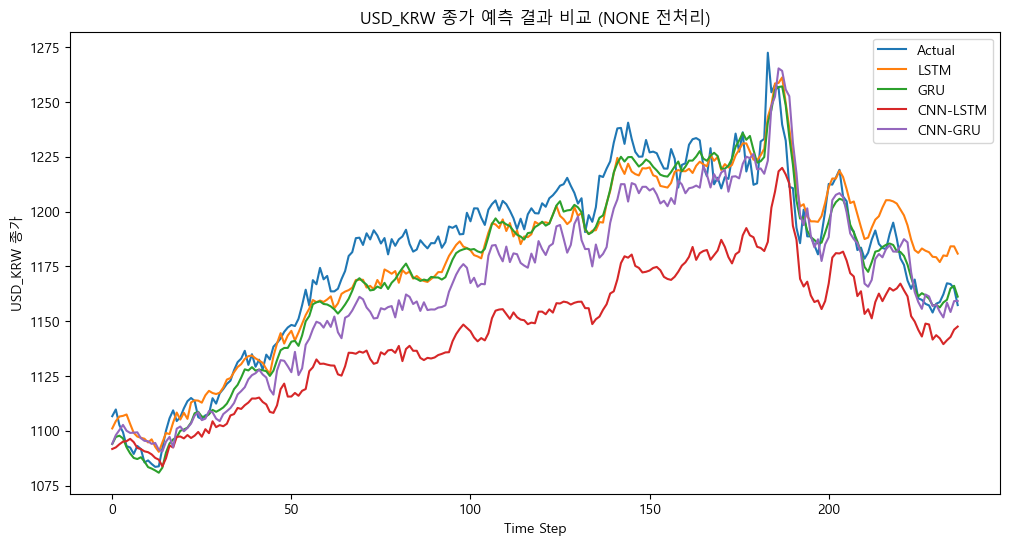

In [41]:
print("===== 시각화 =====")
raw_results = experiment_results_df4['none']
plot_time_series_predictions(raw_results['y_test_inv'], raw_results['models'], method="none")